# **CISC3024 Pattern Recognition Final Project**
## Group Members:
- Huang Yanzhen, DC126732
- Mai Jiajun, DC12785

# 0. Project Setup

## 0.1 Packages & Device

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm import tqdm

import numpy as np
import cv2
import os
import time

In [2]:
device_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)
print(f"Using device: {device_name}")

Using device: cuda


## 0.2 Global Configurations

In [3]:
path_dataset = "./data/SVHN_mat"
norm_mean = [0.4377, 0.4438, 0.4728]
norm_std = [0.1980, 0.2010, 0.1970]

# 1. Data Processing and Augmentation

## 1.1 Download Datasets
Define dataset class, retrieve dataset.

In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import scipy.io as sio

In [5]:
class SVHNDataset(Dataset):
    def __init__(self, mat_file, transform=None):
        data = sio.loadmat(mat_file)
        self.images = np.transpose(data['X'], (3, 0, 1, 2))
        self.labels = data['y'].flatten()
        self.labels[self.labels == 10] = 0
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image=image)['image']

        return image, label

In [6]:
transform = A.Compose([
    A.RandomResizedCrop(32, 32),
    A.Rotate(limit=30),
    A.Normalize(mean=norm_mean, std=norm_std),
    ToTensorV2()
])

train_dataset = SVHNDataset(mat_file=os.path.join(path_dataset,"train_32x32.mat"), transform=transform)
test_dataset = SVHNDataset(mat_file=os.path.join(path_dataset,"test_32x32.mat"), transform=transform)
extra_dataset = SVHNDataset(mat_file=os.path.join(path_dataset,"extra_32x32.mat"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
extra_loader = DataLoader(Subset(extra_dataset, indices=list(range(30000))), batch_size=64, shuffle=False)

print(f"Train Size:{train_dataset.__len__()}\nTest Size:{test_dataset.__len__()}\nExtra Size:{extra_dataset.__len__()}")

Train Size:73257
Test Size:26032
Extra Size:531131


## 1.2 Peak A Data

In [7]:
import random

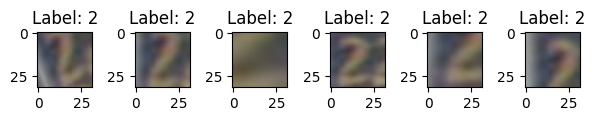

Peaking data from training set of index 35101.
Image Tnesor Size:torch.Size([3, 32, 32])


In [8]:
def unnormalize(img, mean, std):
    """Revert the normalization for visualization."""
    img = img * std + mean
    return np.clip(img, 0, 1)

# Plotting multiple images in a grid
grid_rows, grid_cols = 1, 6

fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(6, 6))

peak_index = random.randint(0, train_dataset.__len__()-1)

for i in range(grid_cols):
    img_tensor, label = train_dataset.__getitem__(peak_index)
    img = img_tensor.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
    img = unnormalize(img, norm_mean, norm_std)

    ax = axes[i]  # Get subplot axis
    ax.imshow(img)
    ax.set_title(f"Label: {label}")

plt.tight_layout()
plt.show()

print(f"Peaking data from training set of index {peak_index}.\nImage Tnesor Size:{train_dataset.__getitem__(peak_index)[0].shape}")

# 2. Neuron Network Structure

## 2.1 Specify Model Structure

In [9]:
class SmallVGG(nn.Module):
    def __init__(self, batch_size=32):
        super(SmallVGG, self).__init__()
        self.batch_size = batch_size
        self. conv_layers = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16x16

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 8x8

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 4x4
        )
    
        self.fc_layers = nn.Sequential(
            nn.Linear(batch_size * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

## 2.2 Initialize with Hyper Parameters

In [10]:
model = SmallVGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

## 2.3 Train and Evaluate

In [39]:
def train_and_evaluate(model,
                      train_loader,
                      test_loader,
                      criterion,
                      optimizer,
                      num_epochs=100):
    # Record Losses to plot
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        # Train
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * len(images)
        train_losses.append(running_loss / len(train_loader))

        # Evaluate
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * len(images)

        test_losses.append(test_loss / len(test_loader))
        print(f"Epoch[{epoch+1}/{num_epochs}], Train Loss:{train_losses[-1]:.4f}, Test Loss:{test_losses[-1]:.4f}")

    return train_losses, test_losses

In [40]:
train_losses, test_losses = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs)
torch.save(model.state_dict(), f"./models/small_vgg_ne-{num_epochs}.pth")

100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.41it/s]


Epoch[1/50], Train Loss:254.3303, Test Loss:194.6120


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:13<00:00, 44.06it/s]


Epoch[2/50], Train Loss:169.5968, Test Loss:152.7738


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 56.05it/s]


Epoch[3/50], Train Loss:145.5373, Test Loss:141.2215


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 57.21it/s]


Epoch[4/50], Train Loss:135.4543, Test Loss:132.0035


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 55.69it/s]


Epoch[5/50], Train Loss:128.7238, Test Loss:124.1816


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:09<00:00, 57.33it/s]


Epoch[6/50], Train Loss:124.4337, Test Loss:117.8175


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 56.51it/s]


Epoch[7/50], Train Loss:121.3505, Test Loss:117.3874


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 55.63it/s]


Epoch[8/50], Train Loss:118.8183, Test Loss:116.2055


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 54.04it/s]


Epoch[9/50], Train Loss:117.2640, Test Loss:109.4819


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 56.79it/s]


Epoch[10/50], Train Loss:114.9739, Test Loss:108.7564


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:09<00:00, 57.87it/s]


Epoch[11/50], Train Loss:113.2627, Test Loss:108.0636


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:09<00:00, 57.57it/s]


Epoch[12/50], Train Loss:112.3431, Test Loss:108.4393


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 55.92it/s]


Epoch[13/50], Train Loss:111.1275, Test Loss:108.1916


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 53.10it/s]


Epoch[14/50], Train Loss:110.1724, Test Loss:105.7632


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 57.07it/s]


Epoch[15/50], Train Loss:110.0078, Test Loss:106.8985


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 54.02it/s]


Epoch[16/50], Train Loss:109.6416, Test Loss:105.3269


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 56.08it/s]


Epoch[17/50], Train Loss:108.5400, Test Loss:103.8726


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 55.19it/s]


Epoch[18/50], Train Loss:108.1969, Test Loss:104.4920


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 55.17it/s]


Epoch[19/50], Train Loss:107.0184, Test Loss:103.3700


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 56.51it/s]


Epoch[20/50], Train Loss:106.5455, Test Loss:103.5486


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 56.98it/s]


Epoch[21/50], Train Loss:105.5994, Test Loss:101.5047


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 56.44it/s]


Epoch[22/50], Train Loss:106.5143, Test Loss:102.8245


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 56.19it/s]


Epoch[23/50], Train Loss:106.2821, Test Loss:100.3499


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 55.74it/s]


Epoch[24/50], Train Loss:105.0737, Test Loss:100.2032


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 57.20it/s]


Epoch[25/50], Train Loss:104.5106, Test Loss:101.9359


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 56.75it/s]


Epoch[26/50], Train Loss:104.5298, Test Loss:101.0336


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 56.54it/s]


Epoch[27/50], Train Loss:103.4900, Test Loss:100.9677


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 55.34it/s]


Epoch[28/50], Train Loss:103.4609, Test Loss:100.9272


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 56.04it/s]


Epoch[29/50], Train Loss:102.9303, Test Loss:99.3694


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 56.71it/s]


Epoch[30/50], Train Loss:103.2424, Test Loss:96.5219


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:09<00:00, 58.29it/s]


Epoch[31/50], Train Loss:103.3930, Test Loss:101.6511


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 55.64it/s]


Epoch[32/50], Train Loss:101.8096, Test Loss:97.6484


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 54.59it/s]


Epoch[33/50], Train Loss:102.0051, Test Loss:99.0366


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 57.19it/s]


Epoch[34/50], Train Loss:101.9528, Test Loss:95.6174


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 56.56it/s]


Epoch[35/50], Train Loss:102.5032, Test Loss:96.5445


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 54.45it/s]


Epoch[36/50], Train Loss:101.5932, Test Loss:98.5890


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 56.51it/s]


Epoch[37/50], Train Loss:101.1319, Test Loss:98.8029


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:09<00:00, 58.07it/s]


Epoch[38/50], Train Loss:100.7794, Test Loss:97.4843


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:09<00:00, 58.29it/s]


Epoch[39/50], Train Loss:101.6229, Test Loss:97.0881


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:09<00:00, 57.61it/s]


Epoch[40/50], Train Loss:100.9631, Test Loss:95.8303


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:09<00:00, 57.76it/s]


Epoch[41/50], Train Loss:100.3314, Test Loss:95.2606


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 56.29it/s]


Epoch[42/50], Train Loss:99.7768, Test Loss:97.5637


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:09<00:00, 57.71it/s]


Epoch[43/50], Train Loss:100.9531, Test Loss:96.7226


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:09<00:00, 57.71it/s]


Epoch[44/50], Train Loss:99.6723, Test Loss:94.3294


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 55.79it/s]


Epoch[45/50], Train Loss:100.3491, Test Loss:94.0271


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 57.08it/s]


Epoch[46/50], Train Loss:99.1165, Test Loss:94.3590


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:09<00:00, 57.41it/s]


Epoch[47/50], Train Loss:100.0888, Test Loss:99.6581


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 54.73it/s]


Epoch[48/50], Train Loss:99.7741, Test Loss:94.9420


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 55.18it/s]


Epoch[49/50], Train Loss:98.7883, Test Loss:96.1746


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 56.05it/s]


Epoch[50/50], Train Loss:98.7643, Test Loss:96.1450


## 2.4 Visualize Result

In [11]:
from sklearn.metrics import (confusion_matrix, accuracy_score,
                            precision_score, recall_score,
                            f1_score, roc_auc_score,
                            roc_curve, precision_recall_curve,
                            average_precision_score)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

### 2.4.0 Predict with Extra Data
First, use the trained model to predict 30,000 image data from `extra.mat`, which is unseen in neither `train.mat` nor `test.mat`. Robustness on `extra` proves the usability of the model.

Results may contain the following:
- Epoch-Loss Curve of model training
- Confusion Matrix
- Accuracy, Precision, Recall and $F_1$ score.

In [12]:
model_state = torch.load("./models/small_vgg_ne-50_lr-1e-3.pth")
model = SmallVGG()
model.load_state_dict(model_state)

model.to(device)
model.eval() 

pred_scores = []  # Prob. of predictions
true_labels = []  # Ground Truth
pred_labels = []  # Label of prediction, i.e., argmax(softmax(pred_scores))

with torch.no_grad():
    for images, labels in tqdm(extra_loader):
        images, labels = images.to(device), labels.to(device)
    
        outputs = model(images)

        pred_scores_batch = nn.functional.softmax(outputs, dim=-1)

        pred_scores.extend(pred_scores_batch.cpu().tolist())
        pred_labels.extend(outputs.argmax(dim=1).tolist())
        true_labels.extend(labels.cpu().tolist())

D:\Temps\temp\ipykernel_19356\306597358.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state = torch.load("./models/small_vgg_ne-50_lr-1e-3.pth")
100%|███████████

In [14]:
true_labels_cpu = true_labels
[print(num, end=" ") for num in true_labels_cpu[:100]]
print("...")

4 7 8 7 1 1 7 4 3 0 2 8 8 3 1 1 7 0 8 1 5 6 4 4 4 6 3 4 4 3 0 1 7 6 0 1 1 0 5 7 5 1 8 5 5 2 9 6 1 5 2 3 5 3 6 9 2 3 4 1 7 7 3 1 2 2 0 1 1 3 1 5 1 1 9 9 4 8 0 5 1 3 8 2 9 5 6 0 7 8 3 0 6 4 0 3 1 1 0 0 ...


In [16]:
pred_labels_cpu = pred_labels
[print(num, end=" ") for num in pred_labels_cpu[:100]]
print("...")

4 1 8 7 1 7 1 7 3 0 2 8 0 3 1 1 7 0 8 1 8 4 4 1 2 6 1 4 4 3 1 1 7 6 0 1 1 0 5 7 5 1 8 5 5 2 9 6 1 5 9 3 5 3 0 9 2 2 4 1 7 7 3 1 2 2 0 1 1 3 1 5 7 1 5 6 4 4 0 5 3 3 1 2 9 5 6 0 1 8 3 7 6 4 0 3 2 1 0 0 ...


In [17]:
pred_scores

[[9.972836778615601e-07,
  0.00042773690074682236,
  0.0012151026166975498,
  4.450819324119948e-05,
  0.998244047164917,
  8.816829904390033e-06,
  7.787796675984282e-06,
  4.488226477405988e-05,
  2.9626871764776297e-06,
  3.2053446830104804e-06],
 [0.01121465489268303,
  0.4159080684185028,
  0.06487943977117538,
  0.03004864603281021,
  0.0009303087135776877,
  0.00010538175411056727,
  0.00031676923390477896,
  0.40187835693359375,
  0.009081654250621796,
  0.0656367838382721],
 [1.0827501739640866e-07,
  1.2128765547458897e-06,
  6.084017877583392e-05,
  3.3209644243470393e-06,
  1.433881635648504e-07,
  6.921978723539723e-08,
  1.9884517314494587e-05,
  1.8190529544881429e-06,
  0.9999122619628906,
  3.9844633192842593e-07],
 [0.0013995533809065819,
  0.09783970564603806,
  0.001680105458945036,
  0.0003155140730086714,
  0.0006483131437562406,
  6.084692358854227e-05,
  0.0006195298046804965,
  0.8971007466316223,
  0.0002198338188463822,
  0.00011587974586291239],
 [0.00503287

### 2.4.1 Epoch-Loss Curves

In [29]:
plt.figure(figsize=(3,3))
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Testing Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Testing Loss Curves")
plt.legend()
plt.show()

NameError: name 'train_losses' is not defined

<Figure size 300x300 with 0 Axes>

### 2.4.2 Confusion Matrix

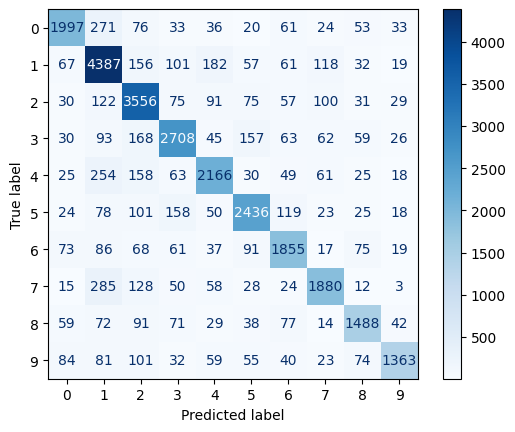

In [18]:
cm = confusion_matrix(true_labels_cpu, pred_labels_cpu)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(0,10))
disp.plot(cmap=plt.cm.Blues)
plt.show()

### 2.4.3 Accuracy, Precision, Recall and $F_1$ Score

In [19]:
accuracy = accuracy_score(true_labels_cpu, pred_labels_cpu)
print(f"Accuracy:{accuracy:.2f}")

precision = precision_score(true_labels_cpu, pred_labels_cpu, average=None, labels=range(0, 10))
recall = recall_score(true_labels_cpu, pred_labels_cpu, average=None, labels=range(0, 10))
f1 = f1_score(true_labels_cpu, pred_labels_cpu, average=None, labels=range(0, 10))           
for i in range(10):
    print(f"Class {i}: Prec:{precision[i]:.2f}, Recall:{recall[i]:.2f}, F_1 Score:{f1[i]:.2f}")

Accuracy:0.79
Class 0: Prec:0.83, Recall:0.77, F_1 Score:0.80
Class 1: Prec:0.77, Recall:0.85, F_1 Score:0.80
Class 2: Prec:0.77, Recall:0.85, F_1 Score:0.81
Class 3: Prec:0.81, Recall:0.79, F_1 Score:0.80
Class 4: Prec:0.79, Recall:0.76, F_1 Score:0.77
Class 5: Prec:0.82, Recall:0.80, F_1 Score:0.81
Class 6: Prec:0.77, Recall:0.78, F_1 Score:0.77
Class 7: Prec:0.81, Recall:0.76, F_1 Score:0.78
Class 8: Prec:0.79, Recall:0.75, F_1 Score:0.77
Class 9: Prec:0.87, Recall:0.71, F_1 Score:0.78


### 2.4.4 ROC curve and ROC AUC
To compute ROC (Receiver Operating Characteristic), we need to first specify positive class using `label_binarize`.

In [21]:
true_labels_bin = label_binarize(true_labels_cpu, classes=range(0,10))
true_labels_bin

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [22]:
pred_labels_bin = label_binarize(pred_labels_cpu, classes=range(0,10))
pred_labels_bin

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [26]:
# Compute ROC AUC for each class
roc_auc = dict()
for i in range(0, 10):
    roc_auc[i] = roc_auc_score(true_labels_bin[:,i], np.array(pred_scores)[:, i])
    print(f"Class {i}: ROC AUC = {roc_auc[i]:.2f}")

Class 0: ROC AUC = 0.98
Class 1: ROC AUC = 0.97
Class 2: ROC AUC = 0.98
Class 3: ROC AUC = 0.97
Class 4: ROC AUC = 0.97
Class 5: ROC AUC = 0.98
Class 6: ROC AUC = 0.97
Class 7: ROC AUC = 0.98
Class 8: ROC AUC = 0.97
Class 9: ROC AUC = 0.97


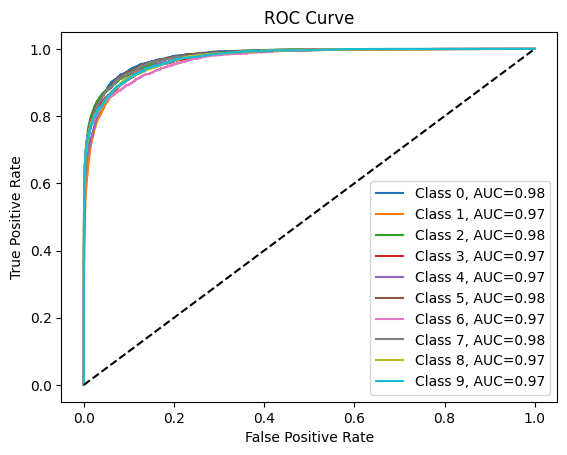

In [33]:
# Plot ROC AUC Curves
for i in range(0, 10):
    fpr, tpr, _ = roc_curve(true_labels_bin[:,i], np.array(pred_scores)[:, i])
    plt.plot(fpr, tpr, label=f"Class {i}, AUC={roc_auc[i]:.2f}")

plt.plot([0, 1], [0, 1], "k--") # Diagnal Line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.yscale("logit")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.show()

### 2.4.5 Precision-Recall Curve

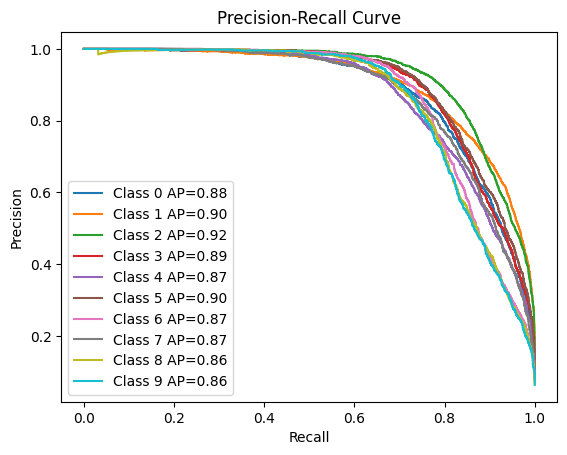

In [35]:
for i in range(0, 10):
    precision_i, recall_i, _ = precision_recall_curve(true_labels_bin[:, i], np.array(pred_scores)[:, i])
    average_precision = average_precision_score(true_labels_bin[:, i], np.array(pred_scores)[:, i])
    plt.step(recall_i, precision_i, where="post", label=f"Class {i} AP={average_precision:.2f}")

plt.xlabel("Recall")
plt.ylabel("Precision")

plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.show()